![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [341]:
import warnings
warnings.filterwarnings('ignore')

In [342]:
# Importación de librerías
#%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [343]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

ESto es la prueba de edición

In [344]:
# Celda 1.1
round(bikes.groupby('season').total.mean(),2)

season
1    116.34
2    215.25
3    234.42
4    198.99
Name: total, dtype: float64

In [345]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

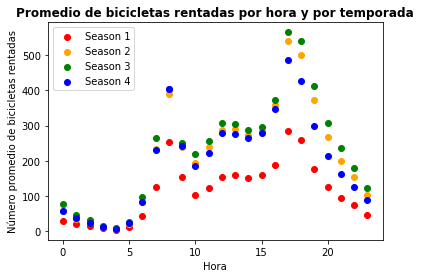

In [346]:
# Calcular el número promedio de bicicletas rentadas por hora y por temporada
hourly_season_avg = bikes.groupby(['season', 'hour'])['total'].mean()

# Crear una lista de colores para cada temporada
colors = ['red', 'orange', 'green', 'blue']

# Crear la gráfica de barras
fig, ax = plt.subplots()

for i, season in enumerate(range(1, 5)):
    season_data = hourly_season_avg.loc[season]
    ax.scatter(season_data.index, season_data.values, color=colors[i], label='Season '+str(season))

# Configurar la gráfica
ax.set_xlabel('Hora')
ax.set_ylabel('Número promedio de bicicletas rentadas')
ax.set_title('Promedio de bicicletas rentadas por hora y por temporada', fontweight = "bold")
ax.legend()

# Mostrar la gráfica
plt.show()


No handles with labels found to put in legend.


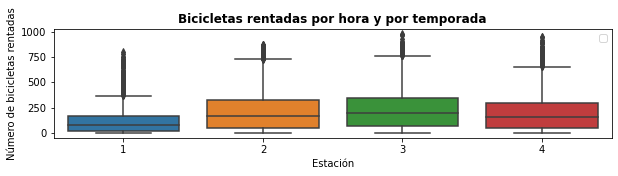

In [347]:
fig = plt.figure(figsize=(10,2))
ax = sns.boxplot(data=bikes, x="season", y='total')
# Configurar la gráfica
ax.set_xlabel('Estación')
ax.set_ylabel('Número de bicicletas rentadas')
ax.set_title('Bicicletas rentadas por hora y por temporada', fontweight = "bold")
ax.legend()

# Mostrar la gráfica
plt.show()


In [348]:
# Agrupar los datos por temporada y calcular las estadísticas descriptivas
stats = bikes.groupby('season')['total'].describe()

# Mostrar las estadísticas descriptivas
print(stats)

         count        mean         std  min   25%    50%    75%    max
season                                                                
1       2686.0  116.343261  125.273974  1.0  24.0   78.0  164.0  801.0
2       2733.0  215.251372  192.007843  1.0  49.0  172.0  321.0  873.0
3       2733.0  234.417124  197.151001  1.0  68.0  195.0  347.0  977.0
4       2734.0  198.988296  177.622409  1.0  51.0  161.0  294.0  948.0


In [349]:
# Se observa que se cuentan con 

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

Text(0.5, 1.0, 'Promedio de bicicletas rentadas por hora')

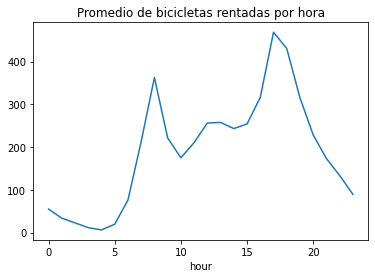

In [350]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()
plt.title('Promedio de bicicletas rentadas por hora')

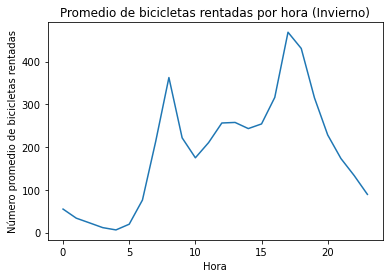

In [351]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
# Filtrar datos para la temporada de invierno
winter_data = bikes[bikes['season'] == 1]

# Calcular el número promedio de bicicletas rentadas por hora
winter_hourly_avg = bikes.groupby('hour').total.mean()

# Crear la gráfica para la temporada de invierno
plt.plot(winter_hourly_avg)
plt.xlabel('Hora')
plt.ylabel('Número promedio de bicicletas rentadas')
plt.title('Promedio de bicicletas rentadas por hora (Invierno)')
plt.show()

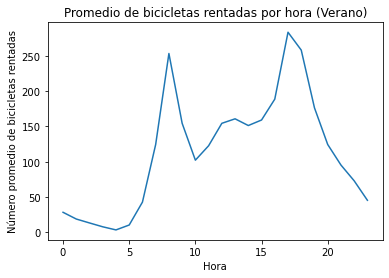

In [352]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
# Filtrar datos para la temporada de verano
summer_data = bikes[bikes['season'] == 3]

# Calcular el número promedio de bicicletas rentadas por hora
summer_data_avg = winter_data.groupby('hour').total.mean()

# Crear la gráfica para la temporada de verano
plt.plot(summer_data_avg)
plt.xlabel('Hora')
plt.ylabel('Número promedio de bicicletas rentadas')
plt.title('Promedio de bicicletas rentadas por hora (Verano)')
plt.show()

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [353]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor

In [354]:
bikes.shape

(10886, 12)

In [355]:
# Convertir la variable 'season' a una variable dummy
bikes['season']= bikes['season'].astype(str)
season_dummies = pd.get_dummies(bikes['season'])
bikes2 = pd.concat([bikes, season_dummies], axis=1)
bikes2.dtypes


season         object
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
total           int64
hour            int64
1               uint8
2               uint8
3               uint8
4               uint8
dtype: object

In [356]:
# Ajustar el modelo de regresión lineal
X = bikes2[['hour','1','2','3','4']]
y = bikes2['total']
model = LinearRegression().fit(X, y)

# Crear un DataFrame de coeficientes
coef_df = pd.DataFrame({'Variable': ['Intercept','hour','1','2','3','4'], 'Coeficiente': [model.intercept_] + list(model.coef_)})

# Imprimir el DataFrame de coeficientes
print(coef_df)

    Variable  Coeficiente
0  Intercept    69.536712
1       hour    10.545206
2          1   -75.966975
3          2    24.350257
4          3    43.500575
5          4     8.116143


La regresión lineal tiene varias limitaciones en este caso. En primer lugar, asume una relación lineal entre las variables predictoras y la variable de respuesta, lo cual puede no ser el caso en la realidad. Además, hay varias variables no incluidas en el modelo que pueden influir en el número de bicicletas rentadas, como la temperatura, la humedad, la velocidad del viento, el día de la semana, entre otras. Por lo tanto, el modelo de regresión lineal puede estar subestimando la complejidad del problema y, por lo tanto, produciendo resultados inexactos o sesgados.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [357]:
features = range(X.shape[1])
features
feature_cols = X.columns

In [358]:
# Celda 4

# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
# Definición de la función gini_imputiry para calular la 
#ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable 
#y punto de cortepara hacer la bifurcación del árbol

def best_split(X, y, num_pct=10):    
    features = range(X.shape[1])
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)        
            if gain > best_split[2]:
                best_split = [j, split, gain]    
    return best_split


# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=None):
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree


def tree_predict(X, tree, proba=False):
    predicted = np.ones(X.shape[0])
    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']  
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]
        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
    return predicted


In [359]:
# Ejecución de función tree_predict
max_depth = range(1, 6)
tree_grow(X, y, level=0, min_gain=0.001, max_depth=1, num_pct=10)
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree_predict(X, tree)

array([1., 1., 1., ..., 1., 1., 1.])

In [360]:
y_true=bikes2['total'].reset_index(drop=True, inplace=True)
y_true

In [361]:
y_pred=tree_predict(X, tree)
y_true=y

In [362]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print("MSE: {:.2f}".format(mse))
print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))
print("MAE: {:.2f}".format(mae))

MSE: 69128.80
RMSE: 262.92
R2: -1.11
MAE: 190.57


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [420]:
# Celda 5
# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 20)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(round(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean(),4))


Text(0, 0.5, 'Accuracy')

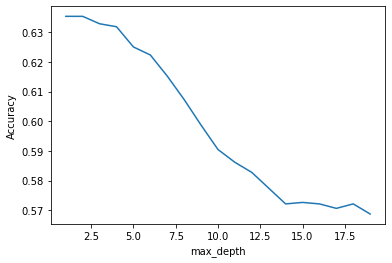

In [421]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [422]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.6353, 2)

In [366]:
# max_depth=4 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=4, random_state=1)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=4, random_state=1)

In [414]:
# Uso de la función .feature_importances_ para obtener la importancia de cada variable
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
0,hour,0.793027
1,1,0.196395
4,4,0.010578
2,2,0.000000
3,3,0.000000


In [368]:
y_pred2 = clf.predict(X)
mse2 = mean_squared_error(y_true, y_pred2)
rmse2 = np.sqrt(mse)
r22 = r2_score(y_true, y_pred)
mae2 = mean_absolute_error(y_true, y_pred2)

print("MSE: {:.2f}".format(mse2))
print("RMSE: {:.2f}".format(rmse2))
print("R2: {:.2f}".format(r22))
print("MAE: {:.2f}".format(mae2))

MSE: 29521.46
RMSE: 262.92
R2: -1.11
MAE: 106.86


In [431]:
# Crear una lista con los nombres de las filas
filas = ['MSE', 'RMSE', 'R2', 'MAE']

# Crear un diccionario con los datos de las columnas
datos = {'Árbol Manual': [mse, rmse,r2, mae],
         'Árbol libreria': [mse2, rmse2,r22, mae2]}

# Crear el DataFrame con los nombres de filas y columnas
tabla = pd.DataFrame(datos, index=filas)

# Imprimir la tabla
tabla

,Árbol Manual,Árbol libreria
MSE,69128.798640,29521.463164
RMSE,262.923560,262.923560
R2,-1.106924,-1.106924
MAE,190.574132,106.863311


## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [380]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [381]:
df['Popular']= pd.Categorical(df['Popular'])

In [389]:
# Definición variable de interes y variables predictoras
X2 = df.drop(['url', 'Popular'], axis=1)
y2 = df['Popular']
#y.mean()

In [390]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, y2, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [430]:
# Celda 6

from sklearn.metrics import accuracy_score, f1_score
#Modelo arbl calibrando profundidad 
# max_depth=4 fue el mejor, se ajusta un árbol usando este valor 

# Definición de 4 modelos diferentes: regresión logística, árbol de decisión,Navie Bayes y k vecinos más cercanos
models = {'linear_regression': LinearRegression(),
          'logreg' = LogisticRegression(),
          'tree_decision': DecisionTreeClassifier(max_depth=50, random_state=1)}

# Entrenamiento (fit) de cada modelo
for model in models.keys():
    models[model].fit(X_train, y_train)

# Predicción de las observaciones del set de test para cada modelo
y_pred = pd.DataFrame(index=X_test.index, columns=models.keys())
for model in models.keys():
    if model=="linear_regression":
        # Predecir las probabilidades de la clase positiva
        y_prob = models[model].predict(X_test)

        # Aplicar un umbral de 0.5 para la predicción binaria
        y_pred[model] = (y_prob > 0.5).astype(int)
    else:
        y_pred[model] = models[model].predict(X_test)
    
# Evaluación del desempeño de cada modelo
for model in models.keys():
    acc = accuracy_score(y_test, y_pred[model])
    f1 = f1_score(y_test, y_pred[model])
    print(f'el Modelo "{model}"; Accuracy = {acc:.4f}, F1-Score = {f1:.4f}")')    

SyntaxError: invalid syntax (Temp/ipykernel_19084/507673040.py, line 9)

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [429]:
# Celda 7
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

#Creación de modelos de acuerdo con las restricciones del problema:
# Crear 100 árboles de decisión con max_depth=5 y 300 muestras bagged
dtree1 = BaggingClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=100, random_state=42)

# Crear 100 árboles de decisión con min_samples_leaf=10 y 300 muestras bagged
dtree2 = BaggingClassifier(DecisionTreeClassifier(min_samples_leaf=10), n_estimators=100, random_state=42)

# Crear 100 regresiones logísticas con regularización L2
logreg = LogisticRegression(penalty='l2', random_state=42, solver='lbfgs', max_iter=1000, n_jobs=-1, verbose=0)

# Crear ensamble de los 3 modelos usando la votación mayoritaria
ensemble = VotingClassifier(estimators=[('dtree1', dtree1), ('dtree2', dtree2), ('logreg', logreg)], voting='hard')

# Entrenar y evaluar cada modelo por separado
models = [dtree1, dtree2, logreg, ensemble]
model_names = ['Decision Tree (max_depth=5)', 'Decision Tree (min_samples_leaf=10)', 'Logistic Regression', 'Ensemble']

for i, model in enumerate(models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{model_names[i]}: Accuracy = {acc:.4f}, F1-Score = {f1:.4f}")

# Evaluar el ensamble de modelos
ensemble.fit(X_train, y_train)
y_pred3 = ensemble.predict(X_test)
acc = accuracy_score(y_test, y_pred3)
f1 = f1_score(y_test, y_pred)
print(f"\nEnsamble Votación mayoritaria:{model_names} Accuracy = {acc:.4f}, F1-Score = {f1:.4f}")

Decision Tree (max_depth=5): Accuracy = 0.6573, F1-Score = 0.6573
Decision Tree (min_samples_leaf=10): Accuracy = 0.6560, F1-Score = 0.6596
Logistic Regression: Accuracy = 0.6180, F1-Score = 0.6029
Ensemble: Accuracy = 0.6547, F1-Score = 0.6537

Ensamble Votación mayoritaria:['Decision Tree (max_depth=5)', 'Decision Tree (min_samples_leaf=10)', 'Logistic Regression', 'Ensemble'] Accuracy = 0.6547, F1-Score = 0.6537


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [428]:
# Celda 8
# Crear ensamble de los 3 modelos usando la votación ponderada
weights = [0.3, 0.5, 0.2] # Pesos para los 3 modelos
ensemble2 = VotingClassifier(estimators=[('dtree1', dtree1), ('dtree2', dtree2), ('logreg', logreg)], voting='soft', weights=weights)

# Evaluar el ensamble de modelos
ensemble2.fit(X_train, y_train)
y_pred3 = ensemble2.predict(X_test)
acc = accuracy_score(y_test, y_pred4)
f1 = f1_score(y_test, y_pred)
print(f"\nEnsamble Votación Ponderada: Accuracy = {acc:.4f}, F1-Score = {f1:.4f}")

Decision Tree (max_depth=5): Accuracy = 0.6573, F1-Score = 0.6573
Decision Tree (min_samples_leaf=10): Accuracy = 0.6560, F1-Score = 0.6596
Logistic Regression: Accuracy = 0.6180, F1-Score = 0.6029
Ensemble: Accuracy = 0.6547, F1-Score = 0.6537

Ensamble Votación Ponderada: Accuracy = 0.6500, F1-Score = 0.6507


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [ ]:
# Celda 9

# Crear una lista con los nombres de las filas
filas = ['Accuracy', 'Decision Tree (min_samples_leaf=10)', 'Logistic Regression']

# Crear un diccionario con los datos de las columnas
datos = {'Votación Máxima': [mse, rmse,r2, mae],
         'Votación Ponderada': [mse2, rmse2,r22, mae2]}

# Crear el DataFrame con los nombres de filas y columnas
tabla = pd.DataFrame(datos, index=filas)

# Imprimir la tabla
print(tabla)